# 1. 환경 설정 및 데이터셋 경로, 클래스 ID 정의

In [1]:
import os
import json
import shutil
from glob import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Matplotlib 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
    print("한글 폰트 설정 완료 (NanumGothic)")
except Exception as e:
    print(f"경고: 한글 폰트 설정 중 오류 발생 ({e}). NanumGothic 폰트가 설치되어 있는지 확인해주세요.")

print("환경 설정 및 라이브러리 임포트 완료")

DATA_ROOT = 'D:/dev/github/codeit_team8_project1/data/raw'

# 훈련 이미지 및 어노테이션 폴더 경로 (원본 TL4)
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images_TL_4')
TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_4')

# dl_idx/dl_name 규칙으로 수정된 TL4 JSON 저장 폴더 (fixed)
TRAIN_ANNO_FIXED_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_4_fixed')
os.makedirs(TRAIN_ANNO_FIXED_DIR, exist_ok=True)

# 56개 클래스 ID (문자열)
target_56_class_ids = {
    '1899', '2482', '3350', '3482', '3543', '3742', '3831', '4542',
    '12080', '12246', '12777', '13394', '13899', '16231', '16261',
    '16547', '16550', '16687', '18146', '18356', '19231', '19551',
    '19606', '19860', '20013', '20237', '20876', '21324', '21770',
    '22073', '22346', '22361', '24849', '25366', '25437', '25468',
    '27732', '27776', '27925', '27992', '28762', '29344', '29450',
    '29666', '30307', '31862', '31884', '32309', '33008', '33207',
    '33879', '34596', '35205', '36636', '38161', '41767'
}

print(f"데이터셋 루트: {DATA_ROOT}")
print(f"훈련 이미지 디렉토리: {TRAIN_IMG_DIR}")
print(f"훈련 어노테이션 디렉토리: {TRAIN_ANNO_DIR}")
print(f"가공된 TL4 어노테이션 디렉토리: {TRAIN_ANNO_FIXED_DIR}")
print(f"\n확인된 target_56_class_ids의 개수: {len(target_56_class_ids)}")

# 디렉토리 존재 여부 확인 및 입력 유도
if not os.path.exists(TRAIN_IMG_DIR) or not os.path.exists(TRAIN_ANNO_DIR):
    print("\n경고: 현재 설정된 데이터셋 경로 중 하나 이상을 찾을 수 없습니다.")
    suggested_root_raw = input("올바른 'data/raw'의 절대 경로를 입력하세요 (예: /home/user/my_project/data/raw): ")

    if os.path.exists(os.path.join(suggested_root_raw, 'train_images_TL_4')) and \
       os.path.exists(os.path.join(suggested_root_raw, 'train_annotations_TL_4')):

        DATA_ROOT = suggested_root_raw
        TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images_TL_4')
        TRAIN_ANNO_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_4')
        TRAIN_ANNO_FIXED_DIR = os.path.join(DATA_ROOT, 'train_annotations_TL_4_fixed')
        os.makedirs(TRAIN_ANNO_FIXED_DIR, exist_ok=True)

        print(f"\n경로가 '{DATA_ROOT}'(으)로 업데이트 되었습니다. 계속 진행합니다.")
        print(f"새 훈련 이미지 디렉토리: {TRAIN_IMG_DIR}")
        print(f"새 훈련 어노테이션 디렉토리: {TRAIN_ANNO_DIR}")
        print(f"새 가공 어노테이션 디렉토리: {TRAIN_ANNO_FIXED_DIR}")
    else:
        print("입력된 경로도 유효하지 않습니다. 프로그램을 종료합니다. 경로를 다시 확인해주세요.")
        exit()

한글 폰트 설정 완료 (NanumGothic)
환경 설정 및 라이브러리 임포트 완료
데이터셋 루트: D:/dev/github/codeit_team8_project1/data/raw
훈련 이미지 디렉토리: D:/dev/github/codeit_team8_project1/data/raw\train_images_TL_4
훈련 어노테이션 디렉토리: D:/dev/github/codeit_team8_project1/data/raw\train_annotations_TL_4
가공된 TL4 어노테이션 디렉토리: D:/dev/github/codeit_team8_project1/data/raw\train_annotations_TL_4_fixed

확인된 target_56_class_ids의 개수: 56


# 2. JSON 파싱 및 데이터 추출, 필터링

In [2]:
# 2. JSON 파싱 및 원본 데이터 추출 (기존 EDA 흐름 그대로)

# --- 헬퍼 함수 정의 ---
def find_json_files_recursively(root_dir):
    json_files = []
    if not os.path.exists(root_dir):
        print(f"경고: JSON 파일을 탐색할 '{root_dir}' 경로가 존재하지 않습니다.")
        return []
    # JSON 파일 경로 패턴에 맞춰 glob 사용 (K-*_json/K-*/.json)
    search_pattern = os.path.join(root_dir, 'K-*_json', 'K-*', '*.json')
    json_files = glob(search_pattern, recursive=True)
    return json_files

print("\n--- 어노테이션 파일 탐색 중 ---", flush=True)
annotation_json_paths = find_json_files_recursively(TRAIN_ANNO_DIR)
print(f"총 훈련 어노테이션 파일 개수: {len(annotation_json_paths)}", flush=True)

if not annotation_json_paths:
    print("어노테이션 JSON 파일을 찾을 수 없습니다. 프로그램을 종료합니다. 경로를 다시 확인해주세요.", flush=True)
    exit()

print("\n--- JSON 파일 파싱 및 데이터 추출 중 (개별 JSON 파일 디버깅 시작) ---", flush=True)
all_image_data = [] # 각 이미지(JSON 파일)의 주요 메타데이터를 저장
all_bbox_data = []  # 각 바운딩 박스 어노테이션 정보를 저장

image_id_counter = 0 # 각 이미지에 고유 ID를 부여 (원본 JSON에 image_id가 1로 고정될 수 있어 별도로 관리)

# 처리된 JSON 파일 수를 카운트하여 디버그 메시지 조절 (너무 많으면 출력 과다)
processed_json_count = 0
debug_message_limit = 100 # 처음 100개 파일까지만 상세 디버그 메시지 출력
skipped_json_count = {
    'images_section_missing': 0,
    'file_name_missing': 0,
    'dl_idx_missing': 0,
    'json_decode_error': 0,
    'other_error': 0
}

for json_path in annotation_json_paths:
    processed_json_count += 1

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            anno_data = json.load(f)

        # 'images' 섹션에서 이미지 파일명 및 주요 메타데이터 추출
        if 'images' not in anno_data or not anno_data['images']:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'images' 섹션이 없거나 비어 있습니다. 건너뜀.", flush=True)
            skipped_json_count['images_section_missing'] += 1
            continue

        img_info = anno_data['images'][0] # 첫 번째 이미지 정보만 사용

        file_name = img_info.get('file_name')
        if not file_name:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'file_name' 필드를 찾을 수 없습니다. 건너뜀.", flush=True)
            skipped_json_count['file_name_missing'] += 1
            continue

        current_dl_idx = img_info.get('dl_idx')
        if not current_dl_idx:
            if processed_json_count <= debug_message_limit:
                print(f"디버그: '{os.path.basename(json_path)}' - 'dl_idx' 필드를 찾을 수 없습니다. 건너뜀.", flush=True)
            skipped_json_count['dl_idx_missing'] += 1
            continue

        image_id_counter += 1

        # 이미지 메타데이터 저장
        image_entry = {
            'image_id': image_id_counter,
            'file_name': file_name,
            'width': img_info.get('width'),
            'height': img_info.get('height'),
            'dl_idx': current_dl_idx,
            'drug_N': img_info.get('drug_N'),  # 약품 고유 ID (K-XXXX)
            'dl_name': img_info.get('dl_name'),
            'dl_company': img_info.get('dl_company'),
            'drug_shape': img_info.get('drug_shape'),
            'color_class1': img_info.get('color_class1'),
            'print_front': img_info.get('print_front'),
            'print_back': img_info.get('print_back'),
            'json_path': json_path  # 어떤 JSON에서 왔는지 기록 (원본 경로)
        }
        all_image_data.append(image_entry)

        # 'annotations' 섹션에서 바운딩 박스 정보 추출
        if 'annotations' in anno_data and anno_data['annotations']:
            for anno in anno_data['annotations']:
                bbox = anno.get('bbox')  # [xmin, ymin, width, height]
                area = anno.get('area')

                if bbox and len(bbox) == 4:
                    all_bbox_data.append({
                        'image_id': image_id_counter,   # 이미지 메타데이터와 연결하기 위한 ID
                        'dl_idx': current_dl_idx,       # 이 바운딩 박스의 클래스 ID (dl_idx)
                        'bbox': bbox,
                        'xmin': bbox[0],
                        'ymin': bbox[1],
                        'bbox_width': bbox[2],
                        'bbox_height': bbox[3],
                        'area': area,
                        'file_name': file_name          # 이 어노테이션이 속한 이미지 파일명
                    })
    except json.JSONDecodeError:
        if processed_json_count <= debug_message_limit:
            print(f"경고: '{os.path.basename(json_path)}' 파일이 유효한 JSON 형식이 아닙니다. 건너뜀.", flush=True)
        skipped_json_count['json_decode_error'] += 1
    except Exception as e:
        if processed_json_count <= debug_message_limit:
            print(f"경고: '{os.path.basename(json_path)}' 처리 중 알 수 없는 오류 발생: {e}. 건너뜀.", flush=True)
        skipped_json_count['other_error'] += 1

print("\n--- JSON 파일 파싱 및 데이터 추출 요약 ---", flush=True)
print(f"총 JSON 파일 개수: {processed_json_count}", flush=True)
print(f"images 섹션 누락/비어있음: {skipped_json_count['images_section_missing']}개", flush=True)
print(f"file_name 필드 누락: {skipped_json_count['file_name_missing']}개", flush=True)
print(f"dl_idx 필드 누락: {skipped_json_count['dl_idx_missing']}개", flush=True)
print(f"JSON Decode 오류: {skipped_json_count['json_decode_error']}개", flush=True)
print(f"기타 오류: {skipped_json_count['other_error']}개", flush=True)
print(f"성공적으로 파싱된 이미지 메타데이터 개수: {len(all_image_data)}개", flush=True)

print("\n--- 추출된 데이터로 DataFrame 생성 중 ---", flush=True)
images_df = pd.DataFrame(all_image_data)
annotations_df = pd.DataFrame(all_bbox_data)

print(f"생성된 images_df 크기: {len(images_df)}개의 이미지 메타데이터", flush=True)
print(f"생성된 annotations_df 크기: {len(annotations_df)}개의 어노테이션", flush=True)

if not images_df.empty:
    print(f"\n총 고유 `dl_idx` 개수 (파싱된 JSON): {images_df['dl_idx'].nunique()}", flush=True)
    print(f"\n`target_56_class_ids`에 정의된 클래스 개수: {len(target_56_class_ids)}", flush=True)
    print("\n--- `images_df`의 `dl_idx`와 `target_56_class_ids`의 교집합 ---", flush=True)
    common_dl_idx = set(images_df['dl_idx'].unique()).intersection(target_56_class_ids)
    print(f"교집합 개수: {len(common_dl_idx)}개", flush=True)
    if len(common_dl_idx) > 0:
        print(f"일치하는 `dl_idx` 예시: {list(common_dl_idx)[:5]}", flush=True)
    else:
        print("`images_df`의 `dl_idx`와 `target_56_class_ids` 사이에 일치하는 항목이 없습니다.", flush=True)
else:
    print("`images_df`가 비어있어 `dl_idx` 정보를 확인할 수 없습니다. JSON 파싱 과정에 문제가 있을 수 있습니다.", flush=True)


--- 어노테이션 파일 탐색 중 ---
총 훈련 어노테이션 파일 개수: 5466

--- JSON 파일 파싱 및 데이터 추출 중 (개별 JSON 파일 디버깅 시작) ---

--- JSON 파일 파싱 및 데이터 추출 요약 ---
총 JSON 파일 개수: 5466
images 섹션 누락/비어있음: 0개
file_name 필드 누락: 0개
dl_idx 필드 누락: 0개
JSON Decode 오류: 0개
기타 오류: 0개
성공적으로 파싱된 이미지 메타데이터 개수: 5466개

--- 추출된 데이터로 DataFrame 생성 중 ---
생성된 images_df 크기: 5466개의 이미지 메타데이터
생성된 annotations_df 크기: 5450개의 어노테이션

총 고유 `dl_idx` 개수 (파싱된 JSON): 65

`target_56_class_ids`에 정의된 클래스 개수: 56

--- `images_df`의 `dl_idx`와 `target_56_class_ids`의 교집합 ---
교집합 개수: 34개
일치하는 `dl_idx` 예시: ['13394', '22073', '16687', '32309', '22361']


# 56개 클래스 이미지 및 어노테이션 복사

In [3]:
# 3. TL4 JSON을 dl_idx/dl_name 규칙으로 수정하여 별도 폴더에 저장 (TRAIN_ANNO_FIXED_DIR)

print("\n--- TL4 JSON을 dl_idx/dl_name 규칙으로 수정하여 fixed 폴더에 저장 ---", flush=True)

fixed_cnt = 0
skipped_cnt = 0
error_cnt = 0

for src_path in annotation_json_paths:
    try:
        with open(src_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"[warn] {os.path.basename(src_path)} 로드 실패: {e}", flush=True)
        error_cnt += 1
        continue

    if 'images' not in data or not data['images']:
        skipped_cnt += 1
        continue

    img0 = data['images'][0]
    dl_idx = img0.get('dl_idx')
    dl_name = img0.get('dl_name')

    if dl_idx is None or dl_name is None:
        skipped_cnt += 1
        continue

    try:
        cat_id = int(dl_idx)
    except ValueError:
        print(f"[warn] dl_idx 정수 변환 실패: {os.path.basename(src_path)}, dl_idx={dl_idx}", flush=True)
        skipped_cnt += 1
        continue

    # categories 섹션을 dl_idx/dl_name 규칙으로 재구성
    data['categories'] = [
        {
            'supercategory': 'pill',
            'id': cat_id,
            'name': dl_name,
        }
    ]

    # annotations 의 category_id 를 dl_idx 로 맞추기
    if 'annotations' in data:
        for anno in data['annotations']:
            anno['category_id'] = cat_id

    # fixed 폴더에 동일한 구조로 저장
    rel_path = os.path.relpath(src_path, TRAIN_ANNO_DIR)
    dst_path = os.path.join(TRAIN_ANNO_FIXED_DIR, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    with open(dst_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    fixed_cnt += 1

print(f"[done] TL4 JSON 수정 완료 수: {fixed_cnt}, 건너뜀: {skipped_cnt}, 에러: {error_cnt}", flush=True)
print(f"수정된 TL4 JSON 루트 폴더: {TRAIN_ANNO_FIXED_DIR}", flush=True)


--- TL4 JSON을 dl_idx/dl_name 규칙으로 수정하여 fixed 폴더에 저장 ---
[done] TL4 JSON 수정 완료 수: 5466, 건너뜀: 0, 에러: 0
수정된 TL4 JSON 루트 폴더: D:/dev/github/codeit_team8_project1/data/raw\train_annotations_TL_4_fixed


In [4]:
# 4. 56개 클래스 필터링 (기존 images_df/annotations_df 기준 그대로)

print(f"\n--- 56개 클래스 필터링 중 ---", flush=True)
# 이미지 메타데이터에서 56개 클래스 필터링
images_df_56_classes = images_df[images_df['dl_idx'].isin(target_56_class_ids)].copy()

# 어노테이션에서 56개 클래스 필터링 (image_id를 통해 images_df와 연결)
annotations_df_56_classes = annotations_df[
    annotations_df['image_id'].isin(images_df_56_classes['image_id'])
].copy()

print(f"필터링된 images_df (56개 클래스): {len(images_df_56_classes)}개의 이미지", flush=True)
print(f"필터링된 annotations_df (56개 클래스): {len(annotations_df_56_classes)}개의 어노테이션", flush=True)

if images_df_56_classes.empty:
    print("\n필터링된 56개 클래스 이미지가 없습니다. `target_56_class_ids` 목록과 JSON의 `dl_idx` 값이 일치하지 않을 가능성이 매우 높습니다. 위의 디버깅 정보를 확인하세요.", flush=True)



--- 56개 클래스 필터링 중 ---
필터링된 images_df (56개 클래스): 2862개의 이미지
필터링된 annotations_df (56개 클래스): 2854개의 어노테이션


In [5]:
# 5. 56개 클래스만 selected_TL_4_data 로 복사 (이미지/JSON)
# JSON은 fixed(TL4_fixed)에서 가져오게 수정

SELECTED_ROOT = os.path.join(DATA_ROOT, 'selected_TL_4_data')
SELECTED_IMG_DIR = os.path.join(SELECTED_ROOT, 'images')
SELECTED_ANNO_DIR = os.path.join(SELECTED_ROOT, 'annotations')

os.makedirs(SELECTED_IMG_DIR, exist_ok=True)
os.makedirs(SELECTED_ANNO_DIR, exist_ok=True)

print(f"\n--- 56개 클래스 이미지 및 어노테이션 파일 '{SELECTED_ROOT}'으로 복사 중 ---", flush=True)

copied_image_count = 0
copied_anno_count = 0

# 이미지 복사 (원본 TL4 기준에서 selected로)
for _, row in images_df_56_classes.iterrows():
    file_name = row['file_name']
    json_path = row['json_path']

    # 원본 TL4 JSON 경로에서 조합 폴더 추출
    # 예: .../train_annotations_TL_4/K-조합_json/K-약코드/파일.json
    combo_dir = os.path.basename(os.path.dirname(os.path.dirname(json_path)))   # K-조합_json
    combo_name = combo_dir.replace('_json', '')                                # K-조합

    # 원본 이미지 경로
    src_img = os.path.join(TRAIN_IMG_DIR, combo_name, file_name)
    dst_img = os.path.join(SELECTED_IMG_DIR, file_name)

    if not os.path.exists(src_img):
        print(f"경고: 원본 이미지 '{src_img}'를 찾을 수 없습니다. (dl_idx: {row['dl_idx']})", flush=True)
        continue

    if not os.path.exists(dst_img):
        shutil.copy2(src_img, dst_img)
        copied_image_count += 1

# 어노테이션(JSON) 복사: fixed 폴더에서 가져옴 (B안)
# images_df_56_classes 에서 사용된 json_path(원본)를 기준으로 fixed 경로를 계산
used_json_paths = sorted(images_df_56_classes['json_path'].unique())

for src_json_orig in used_json_paths:
    rel_path = os.path.relpath(src_json_orig, TRAIN_ANNO_DIR)
    src_json_fixed = os.path.join(TRAIN_ANNO_FIXED_DIR, rel_path)  # fixed 위치
    dst_json = os.path.join(SELECTED_ANNO_DIR, os.path.basename(src_json_fixed))  # 한 폴더에 flat하게 저장

    if not os.path.exists(src_json_fixed):
        print(f"경고: fixed JSON '{src_json_fixed}'를 찾을 수 없습니다.", flush=True)
        continue

    if not os.path.exists(dst_json):
        shutil.copy2(src_json_fixed, dst_json)
        copied_anno_count += 1

print("\n--- 복사 요약 시작 ---", flush=True)
print(f"최종 결과: 총 {copied_image_count}개의 56개 클래스 이미지가 '{SELECTED_IMG_DIR}' 폴더로 복사되었습니다.", flush=True)
print(f"            총 {copied_anno_count}개의 56개 클래스 어노테이션이 '{SELECTED_ANNO_DIR}' 폴더로 복사되었습니다.", flush=True)
print("--- 복사 요약 끝 ---", flush=True)


--- 56개 클래스 이미지 및 어노테이션 파일 'D:/dev/github/codeit_team8_project1/data/raw\selected_TL_4_data'으로 복사 중 ---
경고: 원본 이미지 'D:/dev/github/codeit_team8_project1/data/raw\train_images_TL_4\K-004378-005002-005094-019552\K-004378-005002-005094-019552_0_2_0_2_70_000_200.png'를 찾을 수 없습니다. (dl_idx: 19551)
경고: 원본 이미지 'D:/dev/github/codeit_team8_project1/data/raw\train_images_TL_4\K-004378-005002-005094-019552\K-004378-005002-005094-019552_0_2_0_2_75_000_200.png'를 찾을 수 없습니다. (dl_idx: 19551)
경고: 원본 이미지 'D:/dev/github/codeit_team8_project1/data/raw\train_images_TL_4\K-004378-005002-005094-019552\K-004378-005002-005094-019552_0_2_0_2_90_000_200.png'를 찾을 수 없습니다. (dl_idx: 19551)

--- 복사 요약 시작 ---
최종 결과: 총 1392개의 56개 클래스 이미지가 'D:/dev/github/codeit_team8_project1/data/raw\selected_TL_4_data\images' 폴더로 복사되었습니다.
            총 1395개의 56개 클래스 어노테이션이 'D:/dev/github/codeit_team8_project1/data/raw\selected_TL_4_data\annotations' 폴더로 복사되었습니다.
--- 복사 요약 끝 ---


In [6]:
# 6. selected_TL_4_data 기준으로 다시 파싱하여 EDA용 DataFrame 생성

print("\n--- selected_TL_4_data 기준 JSON 재파싱 중 ---", flush=True)

selected_json_paths = glob(os.path.join(SELECTED_ANNO_DIR, "*.json"))
print(f"selected JSON 파일 수: {len(selected_json_paths)}", flush=True)

sel_all_image_data = []
sel_all_bbox_data = []
sel_image_id_counter = 0

for json_path in selected_json_paths:
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        print(f"[selected warn] {os.path.basename(json_path)} 로드 실패: {e}", flush=True)
        continue

    images = data.get("images", [])
    annotations = data.get("annotations", [])

    if not images:
        continue

    # TL4 구조: 이미지 1장당 JSON 1개라고 가정
    img_info = images[0]
    sel_image_id_counter += 1

    file_name = img_info.get("file_name")
    dl_idx = str(img_info.get("dl_idx")) if img_info.get("dl_idx") is not None else None

    sel_all_image_data.append(
        {
            "image_id": sel_image_id_counter,
            "file_name": file_name,
            "width": img_info.get("width"),
            "height": img_info.get("height"),
            "dl_idx": dl_idx,
            "drug_N": img_info.get("drug_N"),
            "dl_name": img_info.get("dl_name"),
            "dl_company": img_info.get("dl_company"),
            "drug_shape": img_info.get("drug_shape"),
            "color_class1": img_info.get("color_class1"),
            "print_front": img_info.get("print_front"),
            "print_back": img_info.get("print_back"),
            "json_path": json_path,
        }
    )

    # annotations: category_id는 이미 dl_idx로 맞춰져 있다고 가정
    for anno in annotations:
        bbox = anno.get("bbox")
        area = anno.get("area")
        anno_dl_idx = str(anno.get("category_id")) if anno.get("category_id") is not None else None

        if bbox and len(bbox) == 4:
            sel_all_bbox_data.append(
                {
                    "image_id": sel_image_id_counter,
                    "dl_idx": anno_dl_idx,
                    "bbox": bbox,
                    "xmin": bbox[0],
                    "ymin": bbox[1],
                    "bbox_width": bbox[2],
                    "bbox_height": bbox[3],
                    "area": area,
                    "file_name": file_name,
                }
            )

images_df_selected = pd.DataFrame(sel_all_image_data)
annotations_df_selected = pd.DataFrame(sel_all_bbox_data)

print("\n--- selected_TL_4_data 기준 DataFrame 정보 ---", flush=True)
print(f"images_df_selected 크기: {len(images_df_selected)}개", flush=True)
print(f"annotations_df_selected 크기: {len(annotations_df_selected)}개", flush=True)


--- selected_TL_4_data 기준 JSON 재파싱 중 ---
selected JSON 파일 수: 1395

--- selected_TL_4_data 기준 DataFrame 정보 ---
images_df_selected 크기: 1395개
annotations_df_selected 크기: 1393개


# 3. EDA


======== Exploratory Data Analysis (selected_TL_4_data 기준) ========


--- 2.1. 데이터 개요 (Images DataFrame - selected) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      1395 non-null   int64 
 1   file_name     1395 non-null   object
 2   width         1395 non-null   int64 
 3   height        1395 non-null   int64 
 4   dl_idx        1395 non-null   object
 5   drug_N        1395 non-null   object
 6   dl_name       1395 non-null   object
 7   dl_company    1395 non-null   object
 8   drug_shape    1269 non-null   object
 9   color_class1  1269 non-null   object
 10  print_front   1269 non-null   object
 11  print_back    1269 non-null   object
 12  json_path     1395 non-null   object
dtypes: int64(3), object(10)
memory usage: 141.8+ KB
None

--- Images DataFrame 기술 통계 (selected) ---
          image_id   width  height
count 

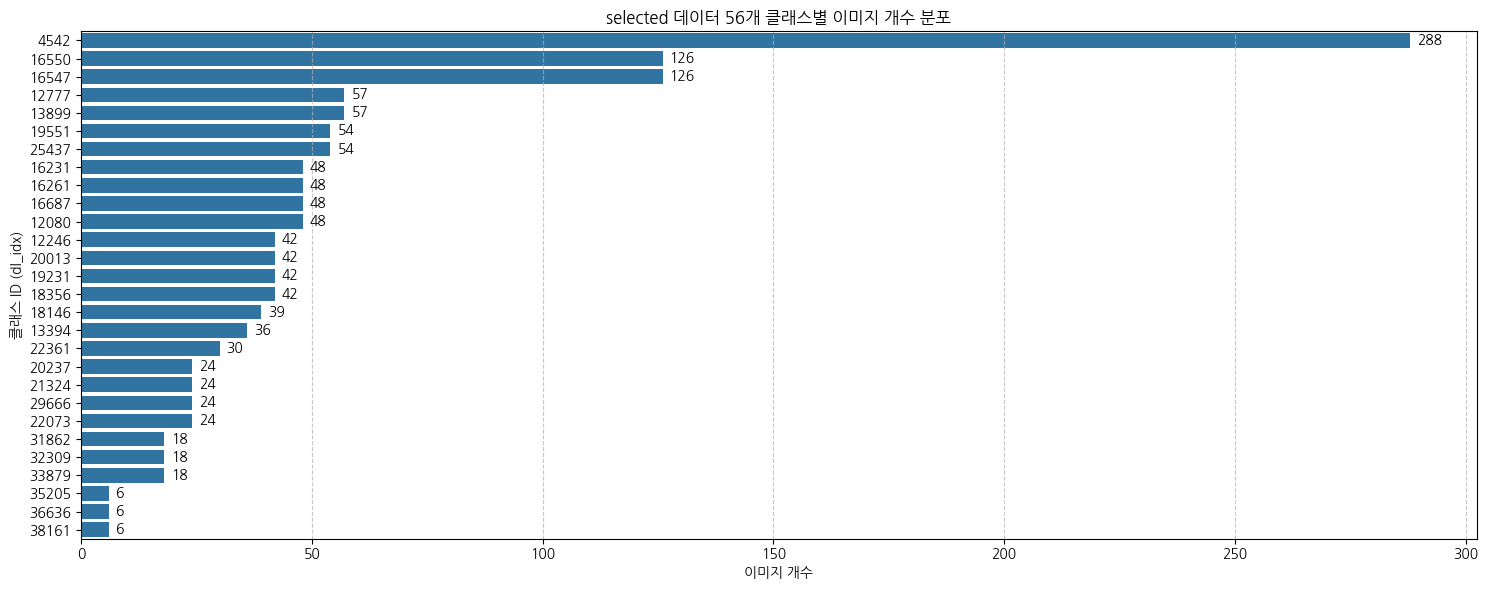

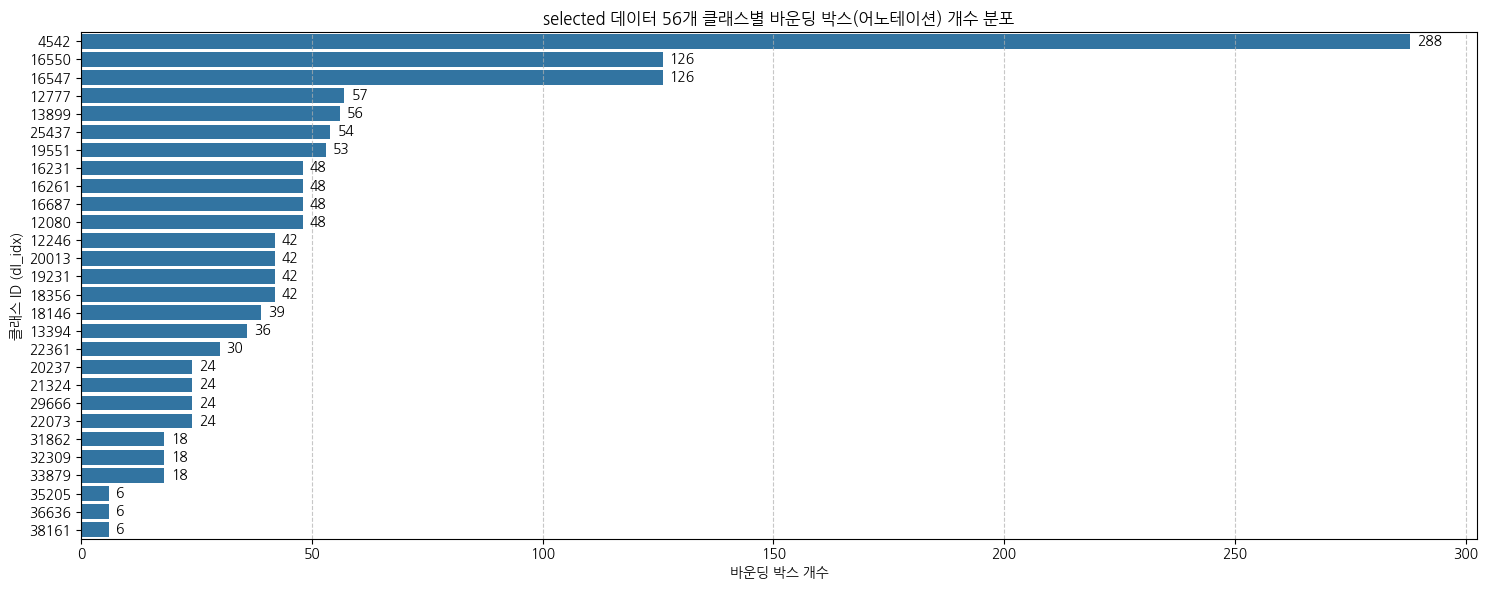


--- 2.4. 이미지 크기 분포 (selected) ---


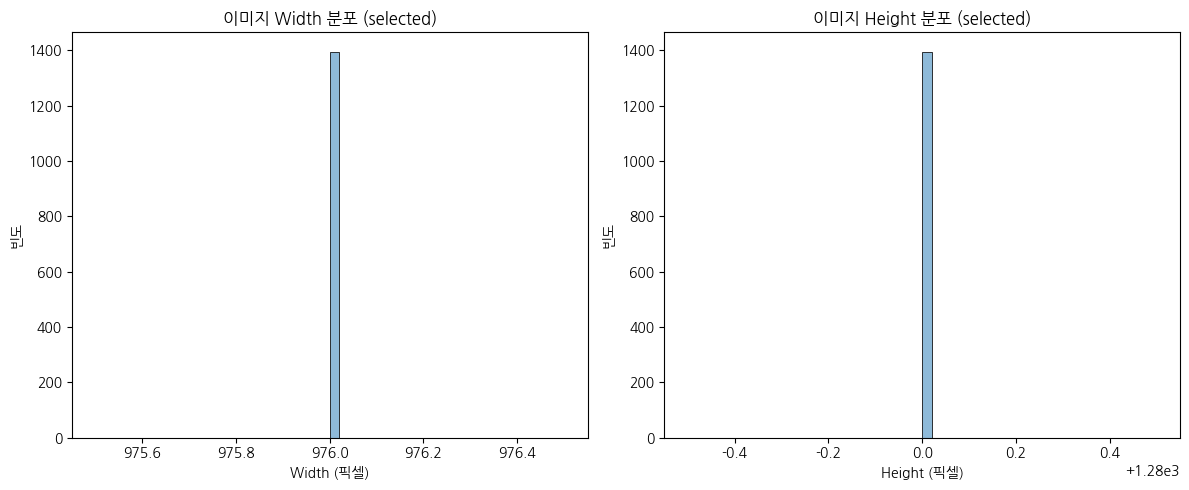

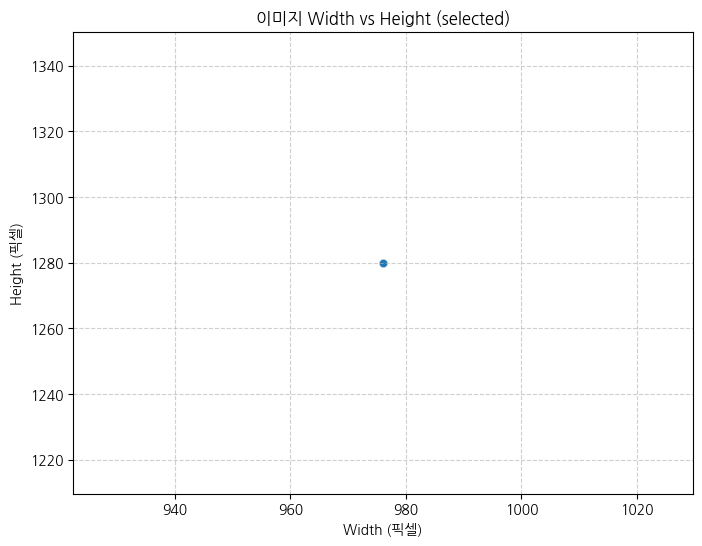


--- 2.5. 바운딩 박스 크기 분포 (selected) ---


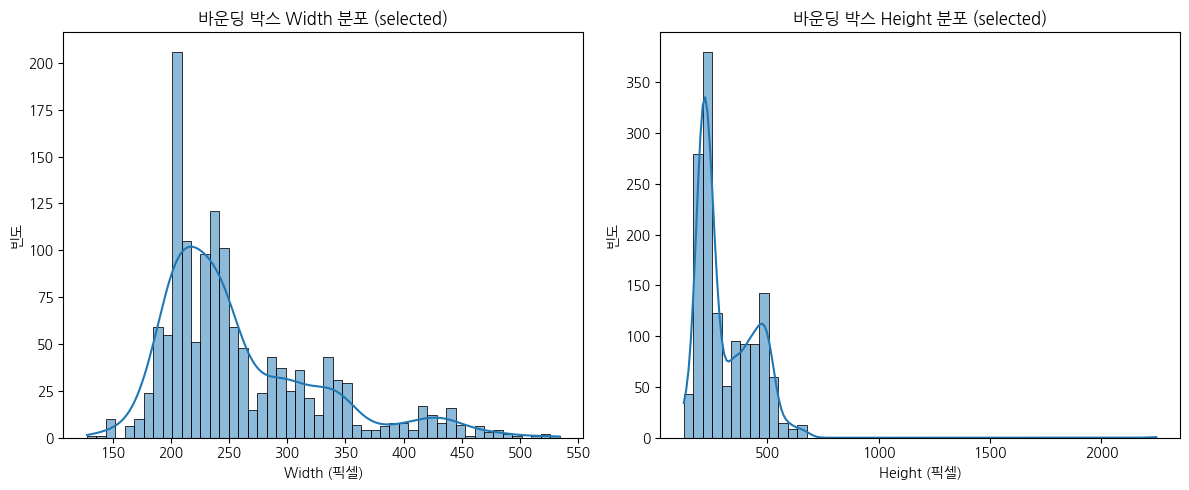

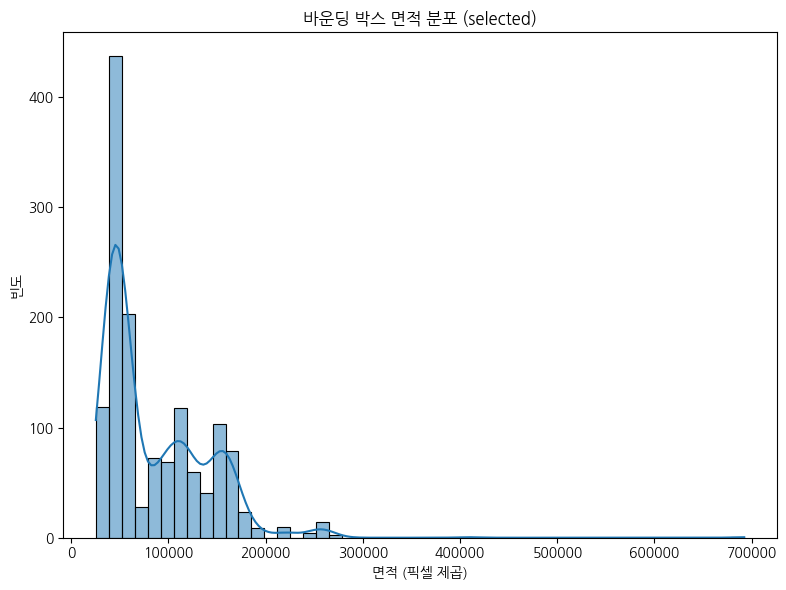

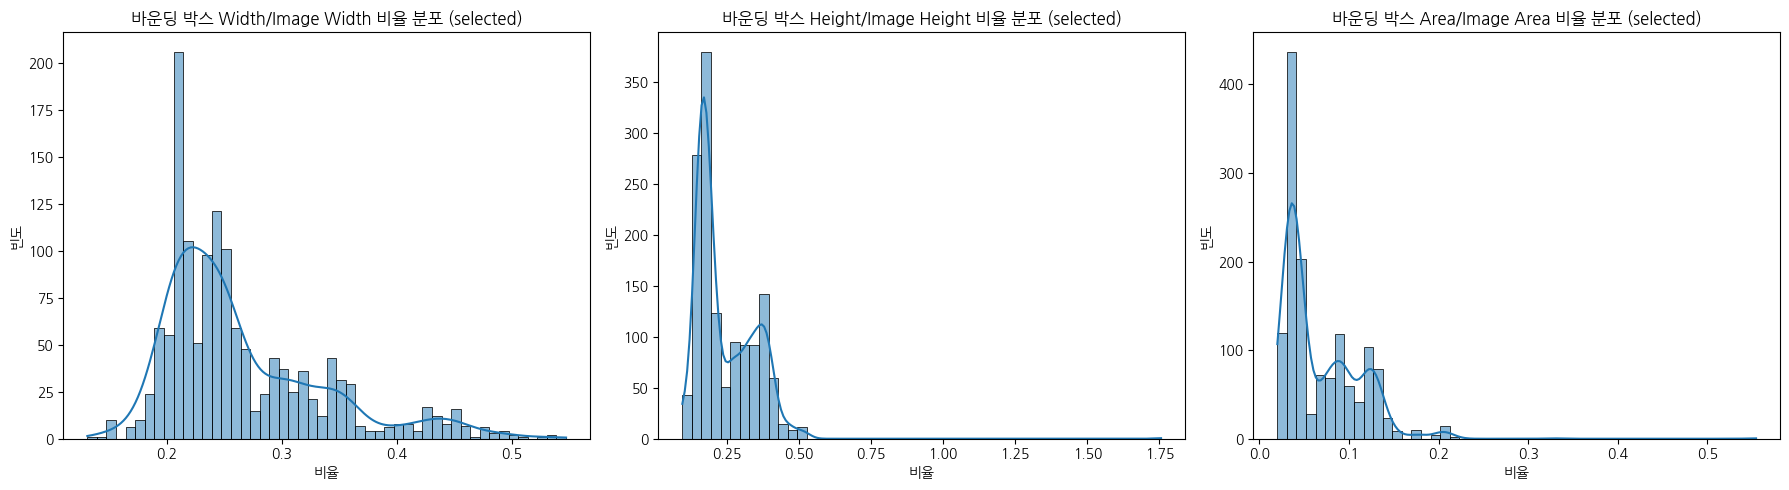


--- 2.6. 알약 속성 분포 (Images DataFrame, selected) ---


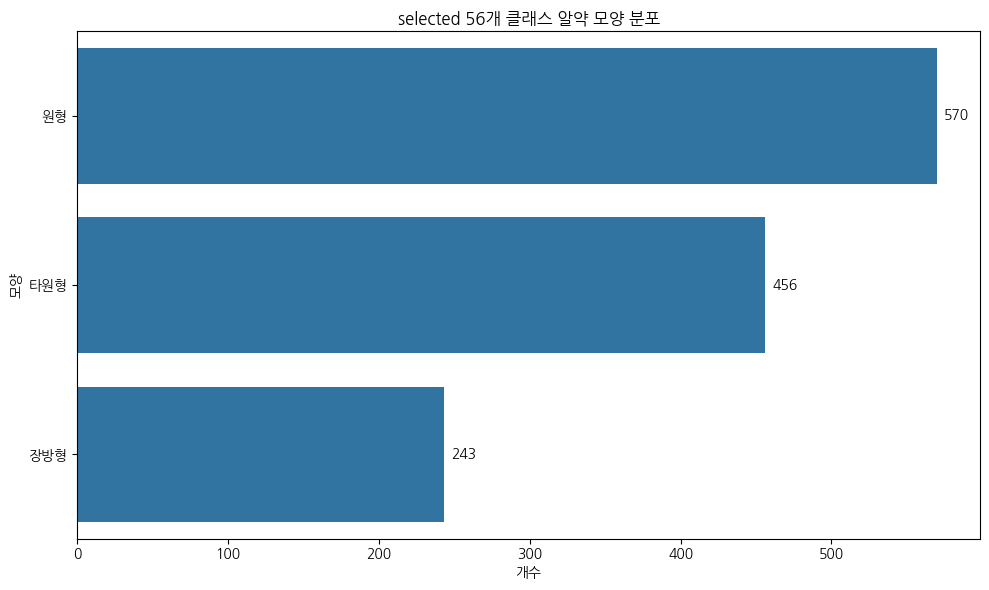

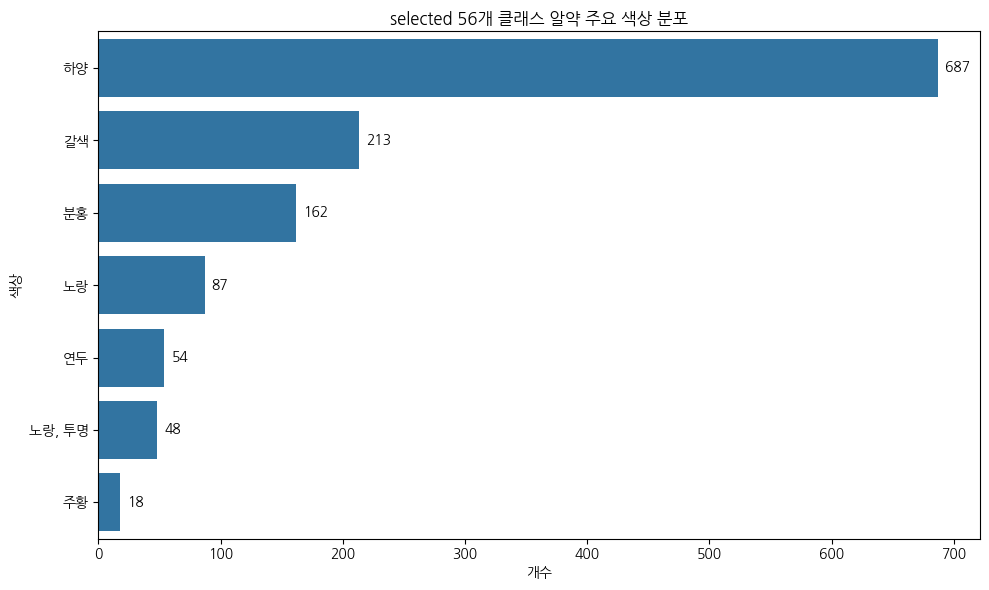


--- 앞면 각인 (print_front) 상위 20개 (selected) ---
print_front
Airtal                 288
DGTH                   126
YH                      78
Y분할선H                   57
M분할선                    57
Q                       54
ATV                     48
ZD452220                48
OMACOR                  48
HMP                     48
RO분할선C분할선HE분할선마크분할선     42
A-008 10                42
HM-CN                   42
GLT400                  42
마크 PGN    150           39
SUSPEN  ER              36
MX                      30
75                      24
마크203                   24
LPL                     24
Name: count, dtype: int64

--- 뒷면 각인 (print_back) 상위 20개 (selected) ---
print_back
         714
800      126
20        72
1분할선0     57
TV        54
YH        54
RP        48
십자분할선     42
분할선       30
1171      24
10        24
JIC       18
Y분할선H      6
Name: count, dtype: int64

--- 2.7. 클래스별 알약 모양 분포 (상위 N개 클래스, selected) ---
drug_shape   원형  타원형
dl_idx              
12777         0   57
13899     

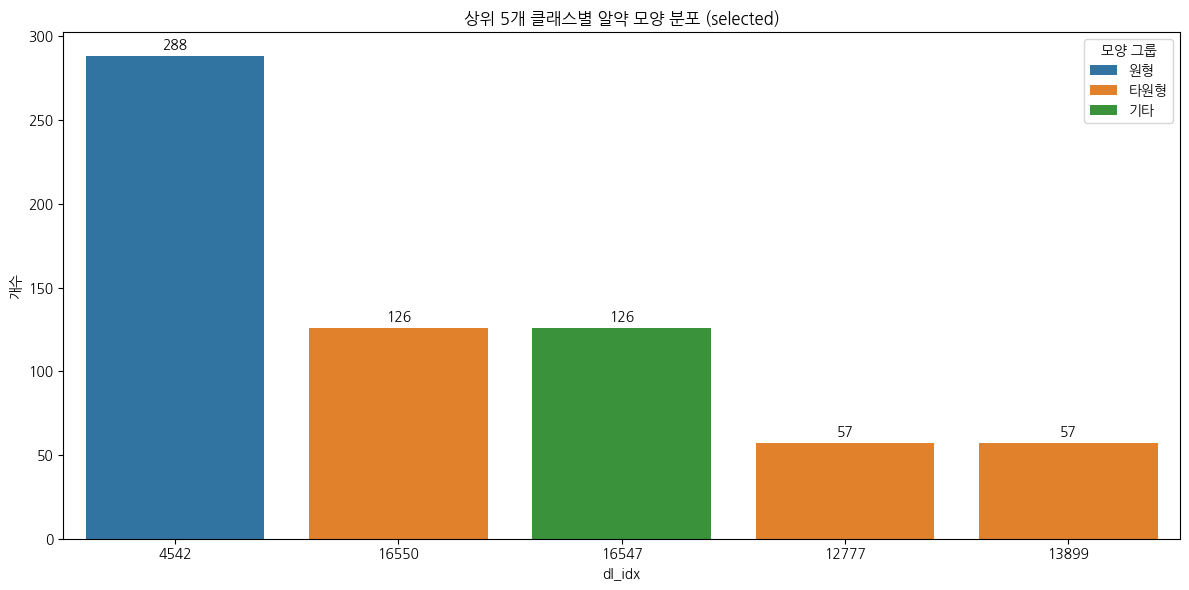


======== EDA 완료 (selected_TL_4_data 기준) ========



In [7]:
# EDA
# 7. selected_TL_4_data 기준 심층 EDA (기존 EDA를 selected DF로 교체)

print("\n=====================================", flush=True)
print("======== Exploratory Data Analysis (selected_TL_4_data 기준) ========", flush=True)
print("=====================================\n", flush=True)

# 2.1. 데이터 개요
print("\n--- 2.1. 데이터 개요 (Images DataFrame - selected) ---", flush=True)
print(images_df_selected.info(), flush=True)
print("\n--- Images DataFrame 기술 통계 (selected) ---", flush=True)
print(images_df_selected.describe(), flush=True)

print("\n--- 2.1. 데이터 개요 (Annotations DataFrame - selected) ---", flush=True)
print(annotations_df_selected.info(), flush=True)
print("\n--- Annotations DataFrame 기술 통계 (selected) ---", flush=True)
print(annotations_df_selected.describe(), flush=True)

# 2.2. 결측치 확인
print("\n--- 2.2. 결측치 확인 (Images DataFrame - selected) ---", flush=True)
print(images_df_selected.isnull().sum(), flush=True)
print("\n--- 2.2. 결측치 확인 (Annotations DataFrame - selected) ---", flush=True)
print(annotations_df_selected.isnull().sum(), flush=True)

# 2.3. 클래스 분포 분석 (Class Distribution)
print("\n--- 2.3. 클래스 분포 분석 (Class Distribution, selected) ---", flush=True)
plt.figure(figsize=(15, 6))
ax = sns.countplot(
    y='dl_idx',
    data=images_df_selected,
    order=images_df_selected['dl_idx'].value_counts().index,
)
plt.title('selected 데이터 56개 클래스별 이미지 개수 분포')
plt.xlabel('이미지 개수')
plt.ylabel('클래스 ID (dl_idx)')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.3.2. dl_idx별 바운딩 박스 개수
plt.figure(figsize=(15, 6))
ax = sns.countplot(
    y='dl_idx',
    data=annotations_df_selected,
    order=annotations_df_selected['dl_idx'].value_counts().index,
)
plt.title('selected 데이터 56개 클래스별 바운딩 박스(어노테이션) 개수 분포')
plt.xlabel('바운딩 박스 개수')
plt.ylabel('클래스 ID (dl_idx)')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.4. 이미지 크기 분포
print("\n--- 2.4. 이미지 크기 분포 (selected) ---", flush=True)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(images_df_selected['width'], kde=True, bins=50)
plt.title('이미지 Width 분포 (selected)')
plt.xlabel('Width (픽셀)')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
sns.histplot(images_df_selected['height'], kde=True, bins=50)
plt.title('이미지 Height 분포 (selected)')
plt.xlabel('Height (픽셀)')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=images_df_selected, alpha=0.5)
plt.title('이미지 Width vs Height (selected)')
plt.xlabel('Width (픽셀)')
plt.ylabel('Height (픽셀)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2.5. 바운딩 박스 크기 분포
print("\n--- 2.5. 바운딩 박스 크기 분포 (selected) ---", flush=True)

# 2.5.1. 바운딩 박스 너비/높이 분포
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(annotations_df_selected['bbox_width'], kde=True, bins=50)
plt.title('바운딩 박스 Width 분포 (selected)')
plt.xlabel('Width (픽셀)')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
sns.histplot(annotations_df_selected['bbox_height'], kde=True, bins=50)
plt.title('바운딩 박스 Height 분포 (selected)')
plt.xlabel('Height (픽셀)')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

# 2.5.2. 바운딩 박스 면적 분포
plt.figure(figsize=(8, 6))
sns.histplot(annotations_df_selected['area'], kde=True, bins=50)
plt.title('바운딩 박스 면적 분포 (selected)')
plt.xlabel('면적 (픽셀 제곱)')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

# 2.5.3. 이미지 대비 바운딩 박스 비율
merged_bbox_data = pd.merge(
    annotations_df_selected,
    images_df_selected[['image_id', 'width', 'height']],
    on='image_id',
    how='left',
)
merged_bbox_data['bbox_width_ratio'] = merged_bbox_data['bbox_width'] / merged_bbox_data['width']
merged_bbox_data['bbox_height_ratio'] = merged_bbox_data['bbox_height'] / merged_bbox_data['height']
merged_bbox_data['bbox_area_ratio'] = merged_bbox_data['area'] / (
    merged_bbox_data['width'] * merged_bbox_data['height']
)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(merged_bbox_data['bbox_width_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Width/Image Width 비율 분포 (selected)')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.subplot(1, 3, 2)
sns.histplot(merged_bbox_data['bbox_height_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Height/Image Height 비율 분포 (selected)')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.subplot(1, 3, 3)
sns.histplot(merged_bbox_data['bbox_area_ratio'], kde=True, bins=50)
plt.title('바운딩 박스 Area/Image Area 비율 분포 (selected)')
plt.xlabel('비율')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

# 2.6. 알약 속성 분포 (Images DataFrame - selected)
print("\n--- 2.6. 알약 속성 분포 (Images DataFrame, selected) ---", flush=True)

# 2.6.1. 약 모양 (drug_shape)
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    y='drug_shape',
    data=images_df_selected,
    order=images_df_selected['drug_shape'].value_counts().index,
)
plt.title('selected 56개 클래스 알약 모양 분포')
plt.xlabel('개수')
plt.ylabel('모양')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.tight_layout()
plt.show()

# 2.6.2. 주요 색상 (color_class1)
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    y='color_class1',
    data=images_df_selected,
    order=images_df_selected['color_class1'].value_counts().index,
)
plt.title('selected 56개 클래스 알약 주요 색상 분포')
plt.xlabel('개수')
plt.ylabel('색상')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)
plt.tight_layout()
plt.show()

# 2.6.3. 앞면 각인 (print_front) - 상위 20개
print("\n--- 앞면 각인 (print_front) 상위 20개 (selected) ---", flush=True)
print(images_df_selected['print_front'].value_counts().head(20), flush=True)

# 2.6.4. 뒷면 각인 (print_back) - 상위 20개
print("\n--- 뒷면 각인 (print_back) 상위 20개 (selected) ---", flush=True)
print(images_df_selected['print_back'].value_counts().head(20), flush=True)

# 2.7. 클래스별 특정 속성 비교 (예: 클래스별 알약 모양 분포)
print("\n--- 2.7. 클래스별 알약 모양 분포 (상위 N개 클래스, selected) ---", flush=True)

# 이미지 개수가 많은 상위 N개 클래스 선택
num_top_classes_for_comparison = min(5, len(images_df_selected['dl_idx'].unique()))
top_dl_idx = (
    images_df_selected['dl_idx']
    .value_counts()
    .head(num_top_classes_for_comparison)
    .index.tolist()
)

top_df = images_df_selected[images_df_selected['dl_idx'].isin(top_dl_idx)]

print(
    top_df.pivot_table(
        index='dl_idx',
        columns='drug_shape',
        aggfunc='size',
        fill_value=0,
    )
)

# 알약 모양 분포
# 상위 N개 클래스 선택(기존 그대로)
num_top_classes_for_comparison = min(5, len(images_df_selected['dl_idx'].unique()))
top_dl_idx = (
    images_df_selected['dl_idx']
    .value_counts()
    .head(num_top_classes_for_comparison)
    .index.tolist()
)

if num_top_classes_for_comparison > 0:
    top_df = images_df_selected[images_df_selected['dl_idx'].isin(top_dl_idx)].copy()

    # 1) 모양을 원형 / 타원형 / 기타 세 그룹으로 묶기
    def map_shape(shape):
        if shape == '원형':
            return '원형'
        elif shape == '타원형':
            return '타원형'
        else:
            return '기타'

    top_df['shape_group'] = top_df['drug_shape'].apply(map_shape)

    # 2) 클래스×모양 그룹으로 집계
    grouped = (
        top_df
        .groupby(['dl_idx', 'shape_group'])
        .size()
        .reset_index(name='count')
    )

    # 3) 막대그래프: x=dl_idx, hue=shape_group
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=grouped,
        x='dl_idx',
        y='count',
        hue='shape_group',
        order=top_dl_idx,          # 클래스 순서 고정
        hue_order=['원형', '타원형', '기타'],  # 범례/색 순서 고정
    )
    plt.title(f'상위 {num_top_classes_for_comparison}개 클래스별 알약 모양 분포 (selected)')
    plt.xlabel('dl_idx')
    plt.ylabel('개수')

    # 각 막대에 숫자 라벨 표시
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3)

    plt.legend(title='모양 그룹')
    plt.tight_layout()
    plt.show()
else:
    print("비교할 클래스가 충분하지 않아 클래스별 알약 모양 분포를 그릴 수 없습니다.", flush=True)

print("\n=====================================", flush=True)
print("======== EDA 완료 (selected_TL_4_data 기준) ========", flush=True)
print("=====================================\n", flush=True)

# 4. 데이터 시각화 (샘플 이미지와 어노테이션)


======== 샘플 이미지 및 어노테이션 시각화 (selected_TL_4_data 기준) ========


--- 무작위 샘플 이미지 5개 시각화 시작 (selected_TL_4_data 기준) ---


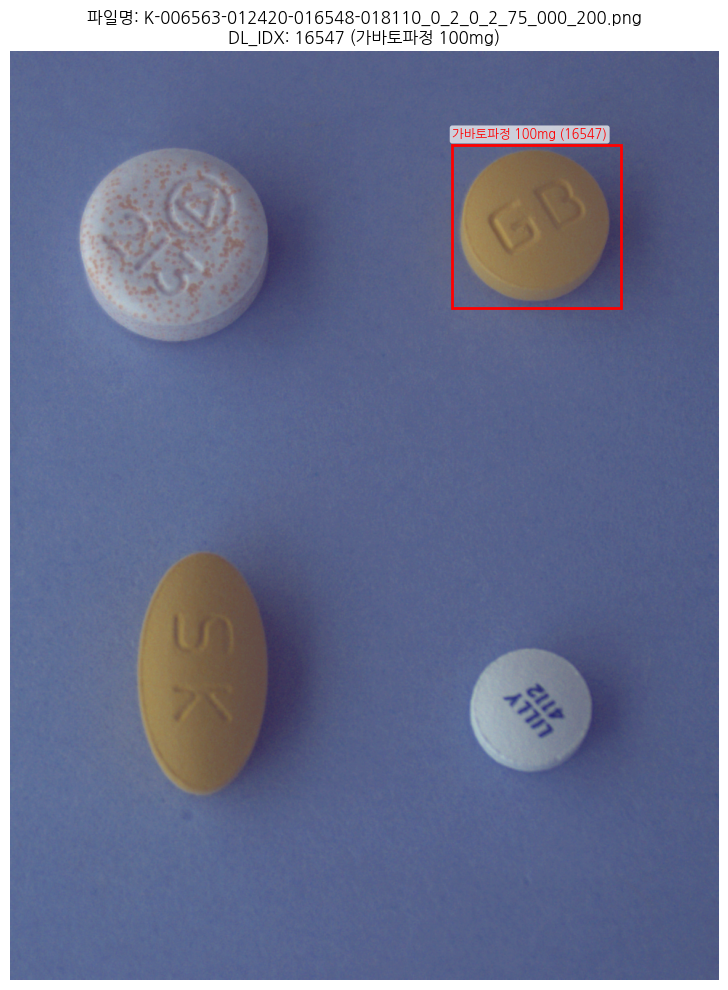

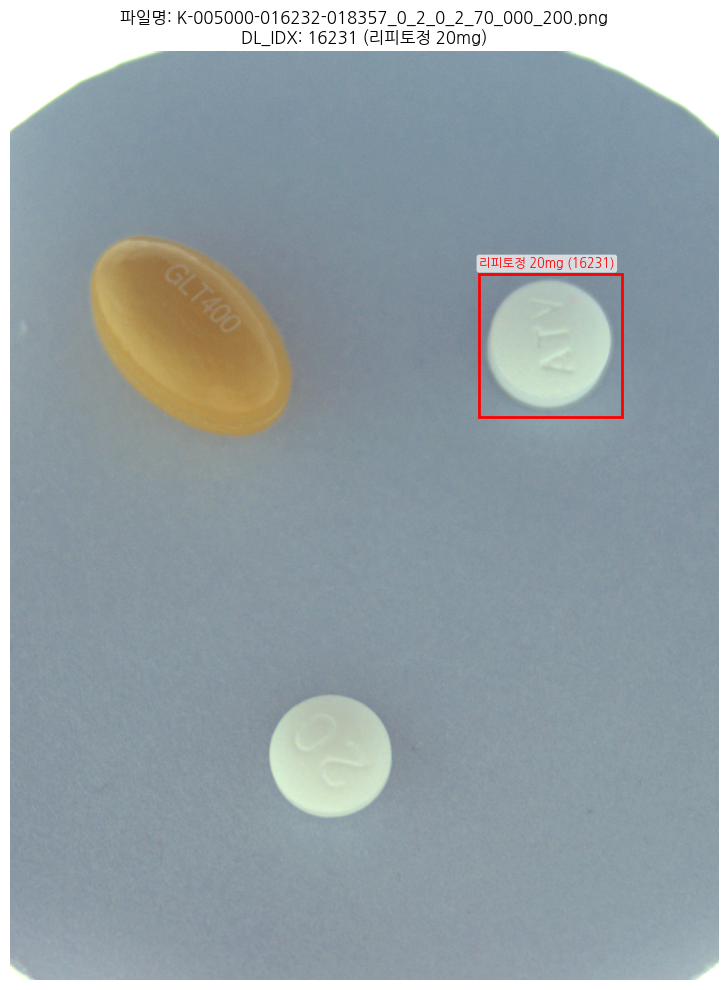

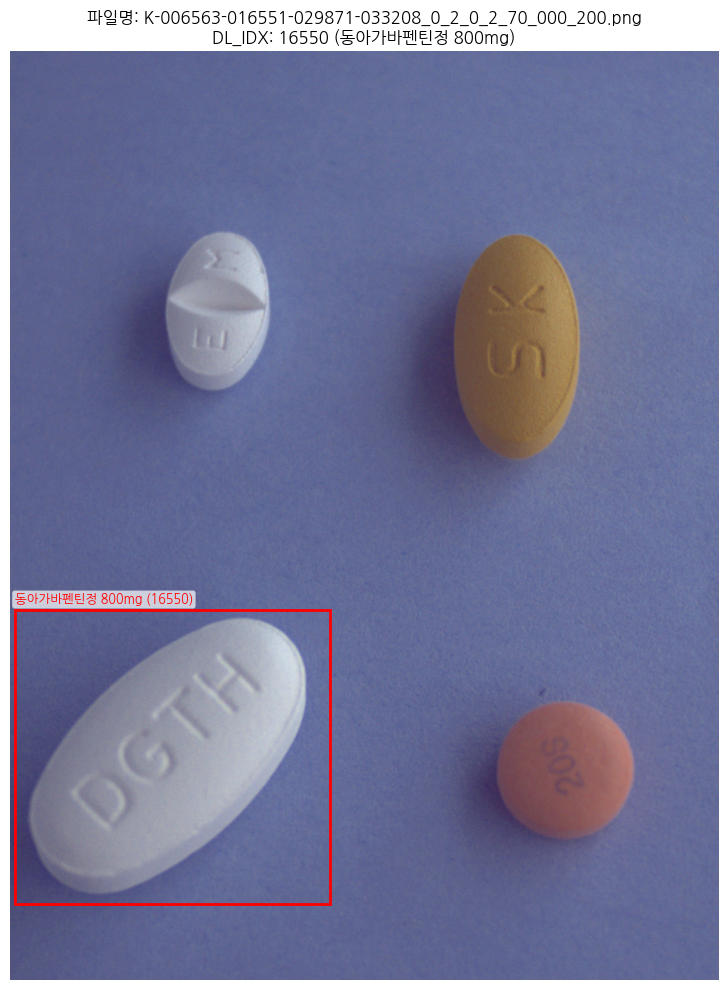

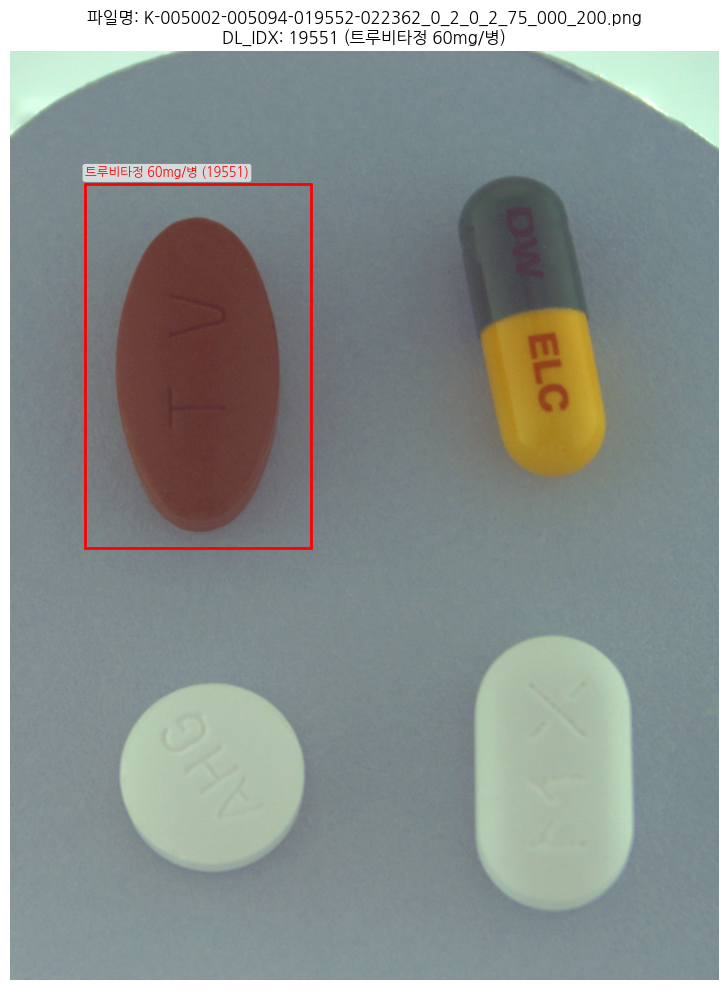

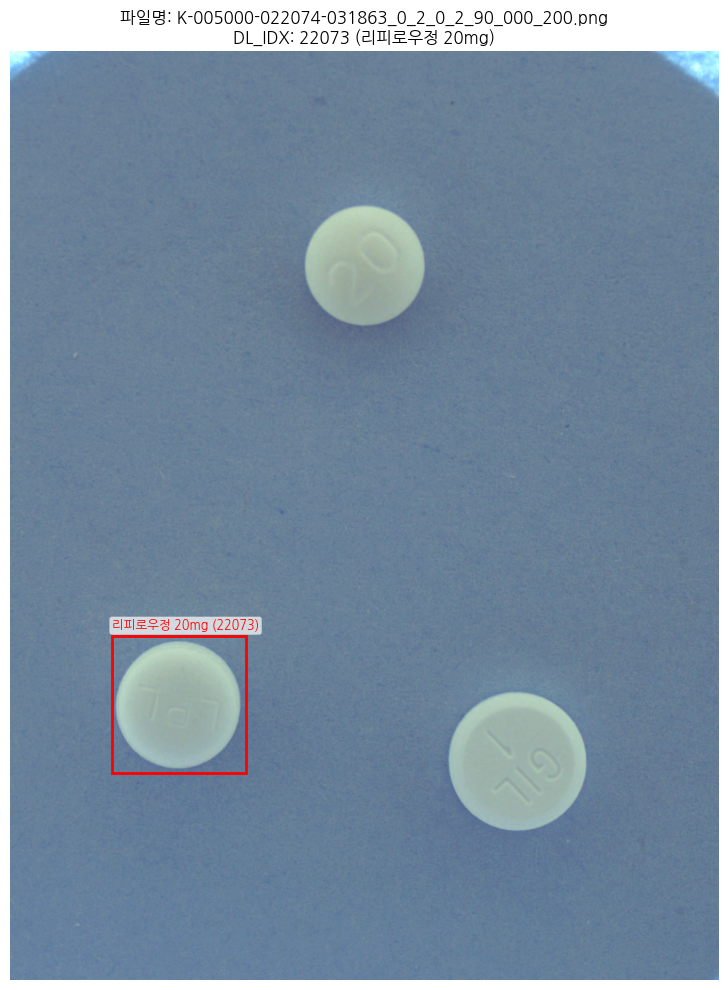


======== 샘플 시각화 완료 (selected_TL_4_data 기준) ========



In [8]:
import matplotlib.patches as patches  # 바운딩 박스를 그리기 위해 임포트
import matplotlib.image as mpimg      # 이미지 로드를 위해 임포트

print("\n=====================================", flush=True)
print("======== 샘플 이미지 및 어노테이션 시각화 (selected_TL_4_data 기준) ========", flush=True)
print("=====================================\n", flush=True)

# --- 헬퍼 함수 정의: selected_TL_4_data 기준 이미지 로드 및 어노테이션 그리기 ---
def plot_image_with_annotations_selected(image_row, annotations_df, base_image_dir):
    """
    selected_TL_4_data 기준 하나의 이미지에 해당하는 바운딩 박스와 정보를 시각화

    Args:
        image_row (pd.Series): images_df_selected DataFrame의 한 행 (이미지 메타데이터).
        annotations_df (pd.DataFrame): annotations_df_selected (전체 어노테이션 DataFrame).
        base_image_dir (str): selected 이미지 파일들이 저장된 루트 디렉토리 (flat 구조).
    """
    image_id = image_row['image_id']
    file_name = image_row['file_name']
    dl_idx = image_row['dl_idx']        # dl_idx (56개 클래스 ID)
    dl_name = image_row['dl_name']      # 알약 이름

    # selected_TL_4_data는 flat 구조이므로 서브폴더 없이 바로 경로 구성
    image_path = os.path.join(base_image_dir, file_name)

    if not os.path.exists(image_path):
        print(f"경고: 이미지 파일 '{image_path}'를 찾을 수 없습니다. 시각화를 건너뜁니다.", flush=True)
        return

    # 이미지 로드
    img = mpimg.imread(image_path)

    # 해당 이미지의 어노테이션 필터링
    img_annotations = annotations_df[annotations_df['image_id'] == image_id]

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    # 이미지 정보 표시
    ax.set_title(f"파일명: {file_name}\nDL_IDX: {dl_idx} ({dl_name})", fontsize=12)
    ax.set_axis_off()

    # 바운딩 박스 그리기
    for _, anno_row in img_annotations.iterrows():
        xmin, ymin, bbox_width, bbox_height = anno_row['bbox']

        # 바운딩 박스 사각형 생성
        rect = patches.Rectangle(
            (xmin, ymin),
            bbox_width,
            bbox_height,
            linewidth=2,
            edgecolor='r',
            facecolor='none',
        )
        ax.add_patch(rect)

        # 알약 이름 (dl_name)과 dl_idx를 바운딩 박스 위에 표시
        label_text = f"{dl_name} ({dl_idx})"
        ax.text(
            xmin,
            ymin - 10,
            label_text,
            color='red',
            fontsize=9,
            backgroundcolor='white',
            bbox=dict(
                facecolor='white',
                alpha=0.7,
                edgecolor='none',
                boxstyle='round,pad=0.2',
            ),
        )

    plt.tight_layout()
    plt.show()


# --- 샘플 이미지 선택 ---
# selected_TL_4_data 기준 56개 클래스 중 무작위로 5개의 이미지를 선택
num_sample_images_to_show = 5
if len(images_df_selected) > 0:
    sample_images = images_df_selected.sample(
        n=min(num_sample_images_to_show, len(images_df_selected)),
        random_state=42,
    )
    print(f"\n--- 무작위 샘플 이미지 {len(sample_images)}개 시각화 시작 (selected_TL_4_data 기준) ---", flush=True)

    # --- 각 샘플 이미지에 대해 시각화 함수 호출 ---
    for _, image_row in sample_images.iterrows():
        plot_image_with_annotations_selected(
            image_row,
            annotations_df_selected,
            SELECTED_IMG_DIR,
        )
else:
    print("\n경고: 시각화할 selected 56개 클래스 이미지가 없어 샘플 시각화를 건너뜁니다.", flush=True)

print("\n=====================================", flush=True)
print("======== 샘플 시각화 완료 (selected_TL_4_data 기준) ========", flush=True)
print("=====================================\n", flush=True)